In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil

In [179]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [180]:
df.shape

(10296, 13)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [182]:
non_metric_features = ["EducDeg", "Children"]
metric_features=df.columns.drop(non_metric_features).to_list()

In [183]:
df.isna().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [184]:
#Check duplicates
df.duplicated().sum()

3

In [185]:
##df = df.astype({'CustID': int, 'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int})


In [186]:
df_filled=df.copy()
modes = df[non_metric_features].mode().loc[0]
df_filled.fillna(modes, inplace=True)
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_filled[metric_features] = imputer.fit_transform(df_filled[metric_features])

In [187]:
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [188]:
nans_index = df.isna().any(axis=1)
df[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,b'2 - High School',NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,b'2 - High School',1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139.0,1979.0,1976.0,b'2 - High School',2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144.0,1996.0,1990.0,b'3 - BSc/MSc',NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,b'2 - High School',2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011.0,NaN,1947.0,b'2 - High School',3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058.0,1983.0,1980.0,b'2 - High School',1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143.0,1986.0,1985.0,b'3 - BSc/MSc',1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [189]:
df_filled[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,b'2 - High School',2541.2,3.0,1.0,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69.0,1983.0,1977.0,b'2 - High School',1399.0,4.0,1.0,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139.0,1979.0,1976.0,b'2 - High School',2538.0,2.0,1.0,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144.0,1996.0,1990.0,b'3 - BSc/MSc',1721.8,4.0,1.0,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185.0,1993.0,1984.0,b'2 - High School',2419.0,4.0,1.0,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011.0,1990.8,1947.0,b'2 - High School',3959.0,2.0,1.0,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058.0,1983.0,1980.0,b'2 - High School',1569.0,4.0,1.0,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143.0,1986.0,1985.0,b'3 - BSc/MSc',1652.0,3.0,1.0,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [190]:
df=df_filled.copy()

In [191]:
##PERGUNTAR SE É EM 2016 OU AGORAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA!!!
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)
#remove from metric_features list
metric_features.remove('BirthYear')
metric_features.append('Age')

In [192]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,10296.0,NaN,NaN,NaN,1991.048155,510.52254,1974.0,1980.0,1986.0,1992.0,53784.0
EducDeg,10296,4,b'3 - BSc/MSc',4816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10296.0,NaN,NaN,NaN,2506.48378,1156.118108,333.0,1706.75,2500.5,3290.0,55215.0
GeoLivArea,10296.0,NaN,NaN,NaN,2.709848,1.26623,1.0,1.0,3.0,4.0,4.0
Children,10296.0,NaN,NaN,NaN,0.707362,0.454996,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10296.0,NaN,NaN,NaN,300.671206,211.65539,-4.11,191.26,299.28,408.3,11604.42
PremHousehold,10296.0,NaN,NaN,NaN,210.431192,352.595984,-75.0,49.45,132.8,290.05,25048.8
PremHealth,10296.0,NaN,NaN,NaN,171.62386,295.806871,-2.11,111.91,162.92,219.235,28272.0


In [193]:
# sorted(df['PremLife'].unique())[-40:]

### Analysis before outliers

In [194]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(5, ceil(len(metric_features) / 5), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

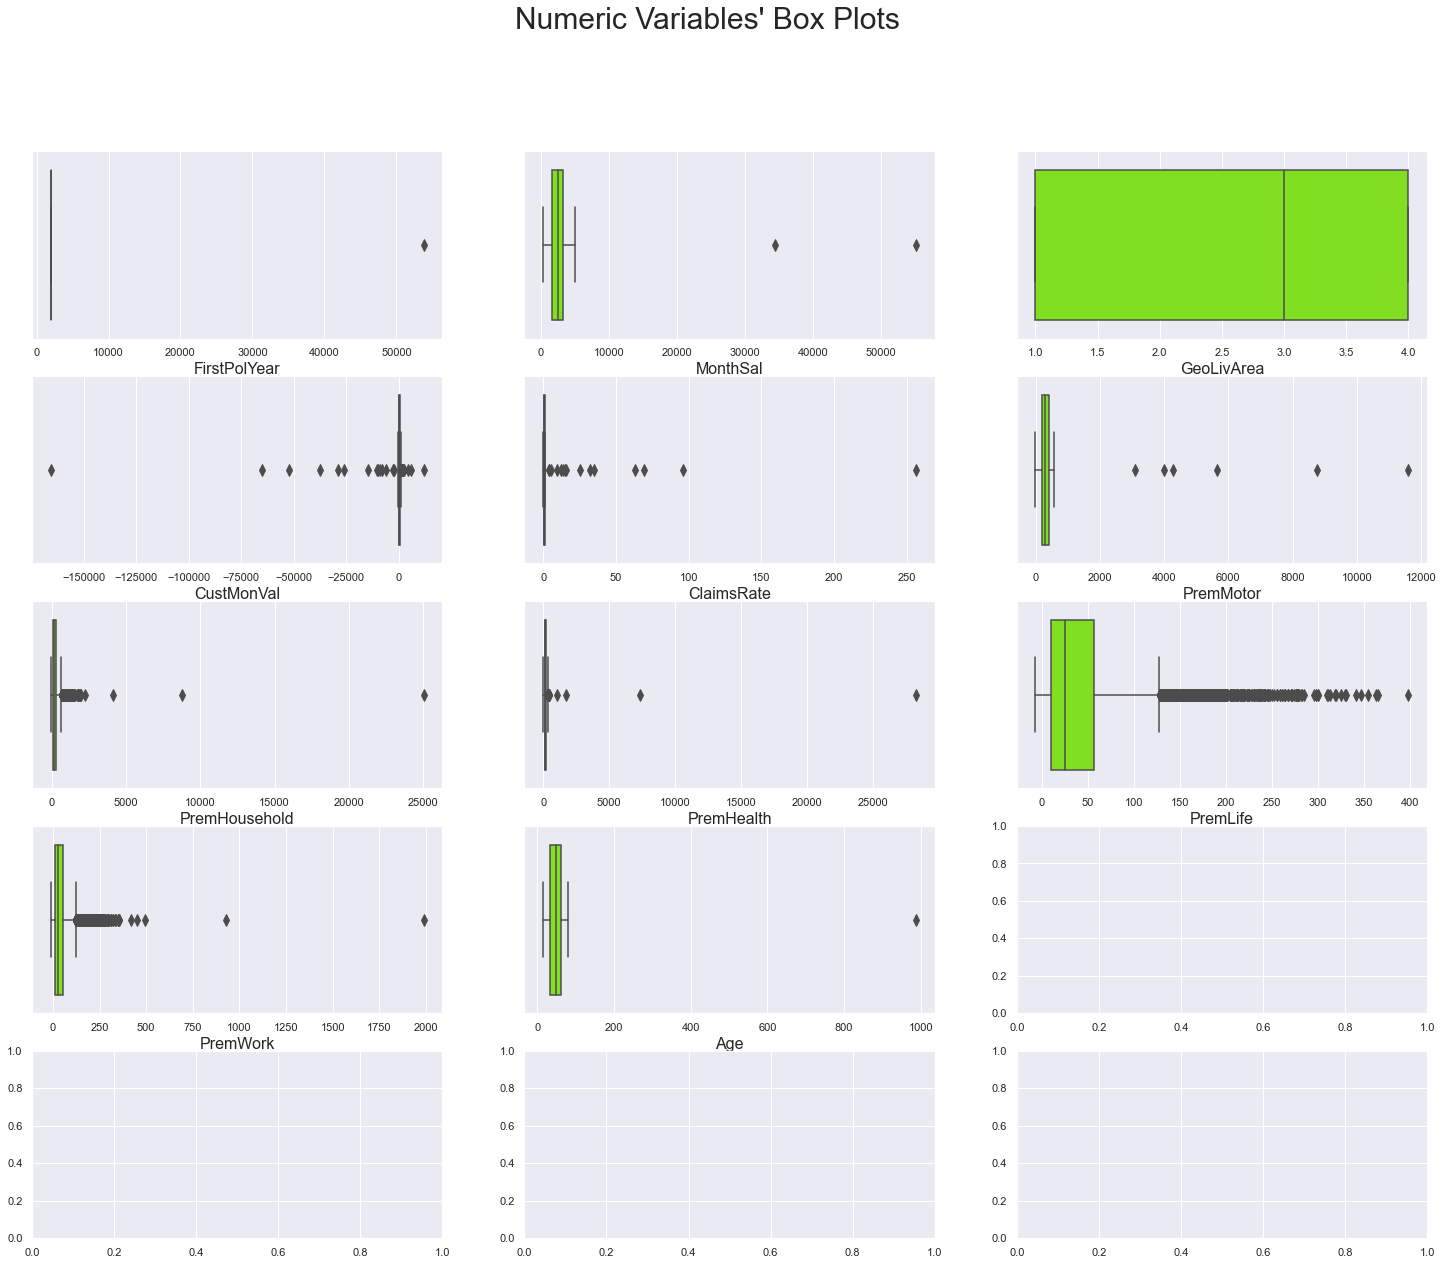

In [195]:
box_plot_all_vars(df)

In [196]:
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [197]:
df_1['FirstPolYear'].unique()

array([1985. , 1991. , 1990. , 1986. , 1979. , 1988. , 1981. , 1976. ,
       1983. , 1977. , 1998. , 1974. , 1978. , 1995. , 1980. , 1984. ,
       1989. , 1987. , 1982. , 1994. , 1993. , 1992. , 1997. , 1996. ,
       1975. , 1981.8, 1979.6, 1984.8, 1992.2, 1987.2, 1987.6, 1988.4,
       1983.2, 1984.6, 1984.2, 1989.8, 1987.4, 1986.6, 1980.4, 1986.8,
       1988.6, 1986.2, 1985.6, 1988.2, 1990.8])

In [198]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8543


In [199]:
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9944


In [200]:
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print(df_3.shape)


Data shape before outliers removal:
(10296, 13)
Data shape after outliers removal:
(10238, 13)


In [201]:
df=df_3.copy()

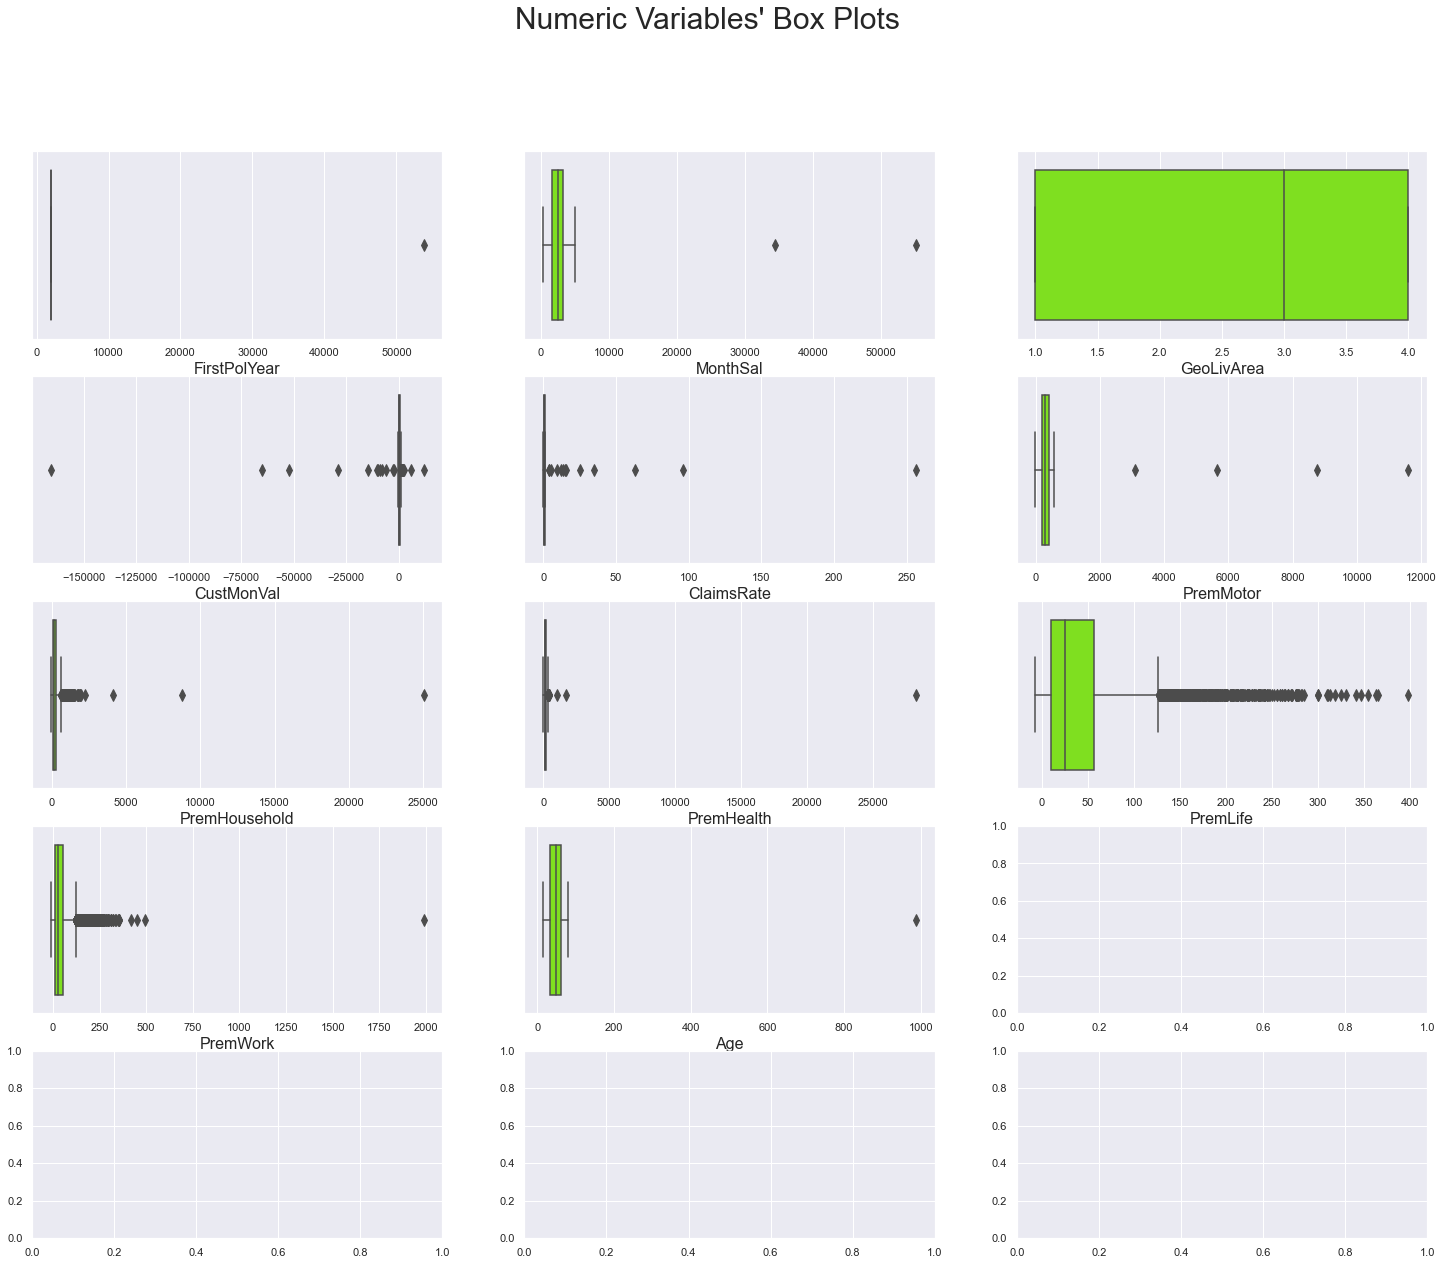

In [202]:
box_plot_all_vars(df)

##### -os dados imputados que criaram years tipo 1998.2 têm de se arredondar 
##### -ver boxplots depois de eliminar outliers
##### -no df['FirstPolYear'].unique aparece um ano 5000 e tal
##### -fazer gráficos de distribuição dos dados
##### -correlações?? para depois colocar scatters??
##### -tratar variável educ
#####